<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import logging
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from rich.logging import RichHandler
from rich.progress import (BarColumn, MofNCompleteColumn, Progress, TextColumn,
                           TimeElapsedColumn, TimeRemainingColumn)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1. Setup the logger to use RichHandler
# This will also log to a file "training.log"
logging.basicConfig(
    level="INFO",
    format="%(message)s",
    datefmt="[%X]",
    handlers=[
        RichHandler(rich_tracebacks=True, show_path=False, markup=True),
        logging.FileHandler("training.log")
    ]
)

# 2. Get the logger instance
logger = logging.getLogger("rich")
logger.info("Logging setup complete. Logs will go to terminal and 'training.log'.")

# 3. Define a helper function to create our custom progress bar
def get_rich_progress_bar():
    """Returns a Rich Progress bar instance."""
    return Progress(
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        MofNCompleteColumn(),
        TimeRemainingColumn(),
        TimeElapsedColumn(),
        # This is a custom field we will update
        TextColumn("[[yellow]Loss: {task.fields[loss]:.4f}[/yellow]]"),
    )

# Custom functions from the repo
from src.common import generate_submission, load_data, prepare_train_data
from src.eval import visualize_retrieval

# Configuration
EPOCHS = 3 # Max epochs for Optuna trials
FINAL_EPOCHS = 100 # More epochs for the final model
MODEL_PATH = "models/mlp_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



SCHEDULER_PATIENCE = 5
EARLY_STOPPING_PATIENCE = 12
DEFAULT_BATCH_SIZE = 2048

# These are fixed from our dataset
INPUT_DIM = 1024  # RoBERTa
OUTPUT_DIM = 1536 # DINOv2

print(f"Using device: {DEVICE}")

[17:08:42] INFO     Logging setup complete. Logs will go to terminal and 'training.log'.

Using device: cuda


In [12]:
# 1. Load data
train_data = load_data("data/train/train.npz")

# 2. Get unique image info *before* creating pairs
all_image_names = train_data['images/names']
n_images = len(all_image_names)
label_matrix = torch.from_numpy(train_data['captions/label']).bool() # [N_captions, N_images]

# 3. Create a random split of IMAGE indices
n_train_images = int(0.9 * n_images)
indices = torch.randperm(n_images)
train_image_indices = indices[:n_train_images]
val_image_indices = indices[n_train_images:]

# 4. Create masks for which images are in which set
train_image_mask = torch.zeros(n_images, dtype=torch.bool)
train_image_mask[train_image_indices] = True
val_image_mask = torch.zeros(n_images, dtype=torch.bool)
val_image_mask[val_image_indices] = True

# 5. Find which CAPTIONS map to which set of images
train_caption_mask = label_matrix[:, train_image_mask].any(dim=1)
val_caption_mask = label_matrix[:, val_image_mask].any(dim=1)

# 6. Now prepare the full X, y data
X, y, _ = prepare_train_data(train_data)

# 7. Apply the LEAK-FREE masks
X_train, X_val = X[train_caption_mask], X[val_caption_mask]
y_train, y_val = y[train_caption_mask], y[val_caption_mask]

print(f"Total Images: {n_images}")
print(f"Train Images: {n_train_images} | Val Images: {n_images - n_train_images}")
print(f"Total Captions: {len(X)}")
print(f"Train Captions: {len(X_train)} | Val Captions: {len(X_val)}")
# --- End of fix ---

DEFAULT_BATCH_SIZE = 2048
K_HARD_NEGATIVES = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

(125000,)
Train data: 125000 captions, 125000 images
Total Images: 25000
Train Images: 22500 | Val Images: 2500
Total Captions: 125000
Train Captions: 112500 | Val Captions: 12500


In [13]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536, 
                 d_model=512, nhead=8, nlayers=3, dim_feedforward=2048, 
                 dropout_rate=0.3):
        """
        A Transformer Encoder-based model to map embeddings, using a [CLS] token.
        
        Args:
            input_dim (int): Dimension of the input embedding (e.g., 1024 for RoBERTa)
            output_dim (int): Dimension of the target embedding (e.g., 1536 for DINOv2)
            d_model (int): The "hidden size" of the Transformer. Must be divisible by nhead.
            nhead (int): The number of attention heads.
            nlayers (int): The number of stacked Transformer Encoder layers.
            dim_feedforward (int): The dimension of the feed-forward network in the encoder.
            dropout_rate (float): The dropout rate to use.
        """
        super().__init__()
        self.d_model = d_model
        
        # 1. Input projection: Project RoBERTa dim (1024) to the Transformer's d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # 2. Learnable [CLS] token
        # This will be prepended to the sequence.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model)) # (Batch, Seq, Dim)
        
        # 3. Learnable positional embedding
        # We now have a sequence of length 2: ([CLS], input_token)
        self.pos_embed = nn.Parameter(torch.zeros(1, 2, d_model)) # (Batch, Seq_len, Dim)
        
        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_rate,
            activation="gelu",
            batch_first=True # Ensures input shape is (Batch, Seq, Dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=nlayers
        )
        
        # 5. Output head
        # Takes the Transformer's output and projects it to DINOv2 dim (1536)
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, output_dim)
        
    def forward(self, x):
        # x shape: (Batch, input_dim)
        
        # 1. Project input to d_model
        x = self.input_proj(x)
        # x shape: (Batch, d_model)
        
        # 2. Add "sequence" dimension -> (Batch, 1, d_model)
        x = x.unsqueeze(1)
        
        # 3. Prepare [CLS] token
        # Get batch size from x
        batch_size = x.size(0)
        # Expand [CLS] token to match batch size -> (Batch, 1, d_model)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        
        # 4. Prepend [CLS] token to the input sequence
        # x shape: (Batch, 2, d_model)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # 5. Add positional embedding (uses broadcasting)
        x = x + self.pos_embed
        
        # 6. Pass through transformer
        # x shape: (Batch, 2, d_model)
        x = self.transformer_encoder(x)
        
        # 7. Get the output of the [CLS] token (the first token)
        # x shape: (Batch, d_model)
        x = x[:, 0, :]
        
        # 8. Normalize and project to final output dimension
        x = self.norm(x)
        x = self.output_head(x)
        # x shape: (Batch, output_dim)
        
        return x

In [14]:
# Modified loss function (calculates loss from a given similarity matrix)
def k_hard_loss_from_sim(sim_matrix, temp, k, device):
    """Calculates InfoNCE with K-Hard Negatives from a similarity matrix."""
    
    # sim_matrix is assumed to be (pred_embs @ true_embs.T) * temp
    b = sim_matrix.size(0)

    # 1. Get positive similarities (the diagonal)
    pos_sim = sim_matrix.diag().clone().unsqueeze(1) # Shape: (B, 1)

    # 2. Get negative similarities
    neg_sim_matrix = sim_matrix.clone()
    neg_sim_matrix.fill_diagonal_(float('-inf'))

    # 3. Find the K hardest negatives
    safe_k = min(k, b - 2)
    if safe_k <= 0:
        labels = torch.arange(b).to(device)
        return F.cross_entropy(sim_matrix, labels)

    hard_k_neg_sims, _ = torch.topk(neg_sim_matrix, k=safe_k, dim=1) # Shape: (B, K)

    # 4. Create new logits and labels
    logits = torch.cat([pos_sim, hard_k_neg_sims], dim=1) # Shape: (B, K+1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)

    # 5. Calculate loss
    loss = F.cross_entropy(logits, labels)
    return loss

# New symmetric loss function
def symmetric_k_hard_loss(predicted_embs, true_image_embs, temp, k, device):
    """
    Calculates the SYMMETRIC InfoNCE loss with K-Hard Negative Mining.
    This version is optimized to compute the similarity matrix only once.
    """
    
    # Normalize embeddings
    pred_embs = F.normalize(predicted_embs, p=2, dim=1)
    true_embs = F.normalize(true_image_embs, p=2, dim=1)

    # Calculate all-pairs similarity matrix ONCE
    sim_matrix_t2i = (pred_embs @ true_embs.T) * temp
    
    # 1. Caption-to-Image Loss (t2i)
    loss_t2i = k_hard_loss_from_sim(sim_matrix_t2i, temp, k, device)
    
    # 2. Image-to-Caption Loss (i2t)
    # Just transpose the matrix! No new multiplication.
    sim_matrix_i2t = sim_matrix_t2i.T 
    loss_i2t = k_hard_loss_from_sim(sim_matrix_i2t, temp, k, device)
    
    # 3. Total Loss
    loss = (loss_t2i + loss_i2t) / 2
    return loss

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import optuna

# Assuming the following are defined globally (as in your notebook):
# EPOCHS, DEVICE, INPUT_DIM, OUTPUT_DIM, 
# TransformerModel, symmetric_k_hard_loss

def run_training_trial(trial, params, train_dataset, val_dataset):
    """
    Train a model for one Optuna trial.
    Accepts a dict of parameters AND the trial object.
    Returns the best validation MRR.
    """
    
    # Create DataLoaders with the suggested batch size
    batch_size = params["batch_size"]
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )   
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        num_workers=4, 
        pin_memory=True
    )   

    # --- NEW: Define scheduler steps ---
    # Assumes EPOCHS is a global constant (e.g., EPOCHS = 10)
    WARMUP_STEPS = len(train_loader) # Warmup for 1 epoch
    TOTAL_STEPS = len(train_loader) * EPOCHS
    
    # Define TransformerModel from params
    model = TransformerModel(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        d_model=params["d_model"],
        nhead=params["nhead"],
        nlayers=params["nlayers"],
        dim_feedforward=params["dim_feedforward"],
        dropout_rate=params["dropout_rate"]
    ).to(DEVICE)
    
    # --- CHANGE: Use AdamW ---
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=params["lr"], 
        weight_decay=params["weight_decay"]
    )
    
    # --- NEW: Initialize Scheduler ---
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=TOTAL_STEPS - WARMUP_STEPS, # Steps *after* warmup
        eta_min=1e-7                      # Minimum LR
    )
    
    best_val_mrr = 0.0
    
    # Assumes EARLY_STOPPING_PATIENCE is defined in your config cell (cell 2)
    early_stopping_patience = 12 
    patience_counter = 0
    
    temp = params["temperature"]
    alpha = params["mixup_alpha"]
    noise_std = params["noise_std"]
    k = params["k_hard_negatives"] # Use k from params

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS): # Use global EPOCHS
        # Training
        model.train()
        train_loss = 0
        
        # --- MODIFICATION: Added 'i' for step counting ---
        for i, (X_batch, y_batch) in enumerate(train_loader): # No tqdm
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            # --- NEW: LR Scheduler & Warmup Logic ---
            current_step = epoch * len(train_loader) + i
            if current_step < WARMUP_STEPS:
                # Linear Warmup
                lr_scale = float(current_step + 1) / float(WARMUP_STEPS)
                for param_group in optimizer.param_groups:
                    # Use the *target* LR from params
                    param_group['lr'] = params["lr"] * lr_scale 
            else:
                # Cosine Decay
                scheduler.step()
            # ----------------------------------------
            
            # --- NEW: Add Gaussian Noise ---
            if noise_std > 0:
                X_batch = X_batch + (torch.randn_like(X_batch) * noise_std)
            # ------------------------------

            # Mixup
            lam = np.random.beta(alpha, alpha)
            indices = torch.randperm(X_batch.size(0)).to(DEVICE)
            X_2, y_2 = X_batch[indices], y_batch[indices]
            X_batch_mixed = lam * X_batch + (1.0 - lam) * X_2
            y_batch_mixed = lam * y_batch + (1.0 - lam) * y_2

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                predicted_embs = model(X_batch_mixed)
                true_image_embs = y_batch_mixed
                
                # --- FIX: Use 'k' from params ---
                loss = symmetric_k_hard_loss(
                    predicted_embs, true_image_embs, temp, k, DEVICE 
                )
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        all_reciprocal_ranks = []
        all_ranks = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                
                with torch.cuda.amp.autocast():
                    predicted_embs = model(X_batch)
                    true_image_embs = y_batch
    
                    predicted_embs = F.normalize(predicted_embs, p=2, dim=1)
                    true_image_embs = F.normalize(true_image_embs, p=2, dim=1)
                    
                    # --- NOTE: Using 'temp' from params here ---
                    sim_matrix = (predicted_embs @ true_image_embs.T) * temp
                    labels = torch.arange(X_batch.size(0)).to(DEVICE)
                    
                    loss = F.cross_entropy(sim_matrix, labels)
                
                val_loss += loss.item()

                correct_scores = sim_matrix.diag().unsqueeze(1) + 1e-6
                ranks = (sim_matrix > correct_scores).sum(dim=1) + 1
                all_ranks.append(ranks)
                all_reciprocal_ranks.append(1.0 / ranks.float())

        val_loss /= len(val_loader)
        
        all_ranks = torch.cat(all_ranks)
        all_reciprocal_ranks = torch.cat(all_reciprocal_ranks)
        mrr = all_reciprocal_ranks.mean().item()
        
        trial.report(mrr, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # --- REMOVED ---
        # scheduler.step(mrr) # This is not needed for CosineAnnealingLR
        # -----------------

        if mrr > best_val_mrr:
            best_val_mrr = mrr
            patience_counter = 0 
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                break
                
    return best_val_mrr

In [16]:
def train_model_final(params, train_dataset, val_dataset, device, epochs):
    """
    Trains the FINAL model using the best parameters and saves it.
    Uses Rich for logging and progress bars.
    """
    logger.info("Training final model with best parameters...")
    logger.info(f"Params: {params}") # Log the parameters
    
    batch_size = params["batch_size"]
    logger.info(f"Using final batch size: {batch_size}")
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )   
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        num_workers=4, 
        pin_memory=True
    )   
    
    # --- NEW: Use the 'epochs' parameter passed to the function ---
    WARMUP_STEPS = len(train_loader) # Warmup for 1 epoch
    TOTAL_STEPS = len(train_loader) * epochs # Use 'epochs' variable

    dim_feedforward = params["d_model"] * params["ff_multiplier"]

    model = TransformerModel(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        d_model=params["d_model"],
        nhead=params["nhead"],
        nlayers=params["nlayers"],
        dim_feedforward=dim_feedforward, # Use the calculated value
        dropout_rate=params["dropout_rate"]
    ).to(device)
    
    # --- CHANGE: Use AdamW ---
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=params["lr"], 
        weight_decay=params["weight_decay"]
    )
    
    # --- NEW: Initialize Scheduler ---
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=TOTAL_STEPS - WARMUP_STEPS, # Steps *after* warmup
        eta_min=1e-7                      # Minimum LR
    )
    
    best_mrr = 0.0 # Track best MRR
    early_stopping_patience = 12
    patience_counter = 0
    
    temp = params["temperature"]
    alpha = params["mixup_alpha"]
    noise_std = params["noise_std"]
    
    if noise_std > 0:
        logger.info(f"Applying Gaussian noise with std: {noise_std:.4f}")
    
    k = params["k_hard_negatives"] # Use k from params
    logger.info(f"Using K-Hard Negatives: {k}")
    
    history = []
    best_val_ranks = None

    scaler = torch.cuda.amp.GradScaler()

    # --- RICH PROGRESS BAR SETUP --
    with get_rich_progress_bar() as progress:
        epoch_task = progress.add_task("[cyan]Epochs", total=epochs, loss=0.0)

        for epoch in range(epochs):
            # --- TRAINING --
            model.train()
            train_loss = 0
            train_task = progress.add_task("[green]   Training", total=len(train_loader), loss=0.0)
            
            # --- MODIFICATION: Added 'i' for step counting ---
            for i, (X_batch, y_batch) in enumerate(train_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # --- NEW: LR Scheduler & Warmup Logic ---
                current_step = epoch * len(train_loader) + i
                if current_step < WARMUP_STEPS:
                    # Linear Warmup
                    lr_scale = float(current_step + 1) / float(WARMUP_STEPS)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = params["lr"] * lr_scale
                else:
                    # Cosine Decay
                    scheduler.step()
                # ----------------------------------------
                
                if noise_std > 0:
                    X_batch = X_batch + (torch.randn_like(X_batch) * noise_std)
                
                lam = np.random.beta(alpha, alpha)
                indices = torch.randperm(X_batch.size(0)).to(device)
                X_2, y_2 = X_batch[indices], y_batch[indices]
                X_batch_mixed = lam * X_batch + (1.0 - lam) * X_2
                y_batch_mixed = lam * y_batch + (1.0 - lam) * y_2

                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    predicted_embs = model(X_batch_mixed)
                    true_image_embs = y_batch_mixed
                    
                    # --- FIX: Use 'k' from params ---
                    loss = symmetric_k_hard_loss(
                        predicted_embs, true_image_embs, temp, k, device
                    )
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                
                progress.update(train_task, advance=1, fields={"loss": loss.item()})
            
            train_loss /= len(train_loader)
            progress.remove_task(train_task)

            # --- VALIDATION ---
            model.eval()
            val_loss = 0
            all_reciprocal_ranks = []
            all_ranks = []
            val_task = progress.add_task("[blue]   Validating", total=len(val_loader), loss=0.0)
            
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    
                    with torch.cuda.amp.autocast():
                        predicted_embs = model(X_batch)
                        true_image_embs = y_batch
        
                        predicted_embs = F.normalize(predicted_embs, p=2, dim=1)
                        true_image_embs = F.normalize(true_image_embs, p=2, dim=1)
                        
                        sim_matrix = (predicted_embs @ true_image_embs.T) * temp
                        labels = torch.arange(X_batch.size(0)).to(DEVICE)
                        
                        loss = F.cross_entropy(sim_matrix, labels)
                    
                    val_loss += loss.item()
                    
                    correct_scores = sim_matrix.diag().unsqueeze(1) + 1e-6
                    ranks = (sim_matrix > correct_scores).sum(dim=1) + 1
                    all_ranks.append(ranks)
                    all_reciprocal_ranks.append(1.0 / ranks.float())
                    
                    progress.update(val_task, advance=1, fields={"loss": loss.item()})

            val_loss /= len(val_loader)
            progress.remove_task(val_task)

            # --- AGGREGATE AND LOG METRICS ---
            all_ranks = torch.cat(all_ranks)
            all_reciprocal_ranks = torch.cat(all_reciprocal_ranks)
            
            r1 = (all_ranks <= 1).float().mean().item()
            r5 = (all_ranks <= 5).float().mean().item()
            r10 = (all_ranks <= 10).float().mean().item()
            mrr = all_reciprocal_ranks.mean().item()
            
            current_lr = optimizer.param_groups[0]['lr']
            
            logger.info(
                f"Epoch {epoch+1:02d}: "
                f"LR=[cyan]{current_lr:.1e}[/] | "
                f"Train Loss=[green]{train_loss:.6f}[/] | "
                f"Val Loss=[blue]{val_loss:.6f}[/] | "
                f"[bold]MRR=[magenta]{mrr:.4f}[/bold]"
            )
            logger.info(
                f"   => Metrics: R@1={r1:.4f} | "
                f"R@5={r5:.4f} | "
                f"R@10={r10:.4f}"
            )
            
            history.append({
                "epoch": epoch + 1, "lr": current_lr, "train_loss": train_loss,
                "val_loss": val_loss, "R@1": r1, "R@5": r5, "R@10": r10, "MRR": mrr
            })
            
            # --- REMOVED ---
            # scheduler.step(mrr) # Not needed for CosineAnnealingLR
            # -----------------

            if mrr > best_mrr:
                best_mrr = mrr
                Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
                torch.save(model.state_dict(), MODEL_PATH)
                logger.info(f"   [bold green]✓ Saved best model (MRR={mrr:.6f})[/bold green]")
                patience_counter = 0 
                best_val_ranks = all_ranks.cpu().numpy() # Save ranks
            else:
                patience_counter += 1
                logger.warning(f"   [yellow]! No improvement. Patience: {patience_counter}/{early_stopping_patience}[/yellow]")
                if patience_counter >= early_stopping_patience:
                    logger.warning(f"--- Early stopping triggered after {epoch + 1} epochs ---")
                    break 
            
            progress.update(epoch_task, advance=1, fields={"loss": val_loss})

    logger.info(f"Training complete. Best model saved to {MODEL_PATH}")
    model.load_state_dict(torch.load(MODEL_PATH))
    return model, history, best_val_ranks

In [17]:
def objective(trial):
    
    # --- Transformer Hyperparameters ---
    nhead = trial.suggest_categorical('nhead', [8, 16]) 
    d_model = trial.suggest_categorical('d_model', [768, 1024])
    # ----------------------------------------------------------------
    
    # --- Suggest a multiplier, not a dynamic value ---
    ff_multiplier = trial.suggest_categorical('ff_multiplier', [4, 6, 8])
    dim_feedforward = d_model * ff_multiplier
    
    nlayers = trial.suggest_int('nlayers', 1, 6)
    
    # --- MODIFICATION: Add k_hard_negatives ---
    k_hard_negatives = trial.suggest_categorical('k_hard_negatives', [128, 256, 512])
    
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 5e-4, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        
        'nhead': nhead,
        'd_model': d_model,
        'nlayers': nlayers,
        'dim_feedforward': dim_feedforward,
        'noise_std': trial.suggest_float('noise_std', 0.0, 0.025),
        
        'dropout_rate': trial.suggest_float('dropout_rate', 0.3, 0.5),
        'temperature': trial.suggest_float('temperature', 28.0, 33.0),
        'mixup_alpha': trial.suggest_float('mixup_alpha', 0.4, 0.6),
        
        'batch_size': trial.suggest_categorical('batch_size', [8192]),
        
        # --- MODIFICATION: Pass k_hard_negatives to params ---
        'k_hard_negatives': k_hard_negatives
    }

    # 1. Pass the 'trial' object to the training function
    best_val_mrr = run_training_trial(trial, params, train_dataset, val_dataset)

    # 2. Return the score
    return best_val_mrr

In [18]:
print("Starting hyperparameter search...")

study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=50)

print("\\nSearch complete!")
print(f"Best validation MRR: {study.best_value:.6f}")
print("Best parameters found:")
print(study.best_params)

best_params = study.best_params

[I 2025-11-10 17:08:56,664] A new study created in memory with name: no-name-b61616cf-cda0-4e4f-beb8-998f913a2f72


Starting hyperparameter search...


[I 2025-11-10 17:09:20,328] Trial 0 finished with value: 0.14463414251804352 and parameters: {'nhead': 8, 'd_model': 1024, 'ff_multiplier': 8, 'nlayers': 4, 'k_hard_negatives': 128, 'lr': 7.460838776045522e-05, 'weight_decay': 3.22543124807746e-05, 'noise_std': 0.002809658602139903, 'dropout_rate': 0.49019343714805264, 'temperature': 28.332294000568936, 'mixup_alpha': 0.5154541146288248, 'batch_size': 8192}. Best is trial 0 with value: 0.14463414251804352.
[I 2025-11-10 17:09:37,787] Trial 1 finished with value: 0.15720440447330475 and parameters: {'nhead': 8, 'd_model': 768, 'ff_multiplier': 6, 'nlayers': 3, 'k_hard_negatives': 128, 'lr': 0.0002836027085969069, 'weight_decay': 7.3926042056209455e-06, 'noise_std': 0.004061699721453077, 'dropout_rate': 0.40063502168823706, 'temperature': 28.913670142695253, 'mixup_alpha': 0.4534719187046112, 'batch_size': 8192}. Best is trial 1 with value: 0.15720440447330475.
[I 2025-11-10 17:09:58,425] Trial 2 finished with value: 0.04225101321935654 

\nSearch complete!
Best validation MRR: 0.311724
Best parameters found:
{'nhead': 8, 'd_model': 1024, 'ff_multiplier': 8, 'nlayers': 2, 'k_hard_negatives': 256, 'lr': 0.0004996665312885849, 'weight_decay': 7.878050590161944e-05, 'noise_std': 0.020307435732479166, 'dropout_rate': 0.4211884065751527, 'temperature': 29.45266252052203, 'mixup_alpha': 0.5344232467036271, 'batch_size': 8192}


In [19]:
# Use the best parameters found by the study
# If you want to use the ones from your log, uncomment the line below
#best_params =  {'nhead': 16, 'd_model': 1024, 'ff_multiplier': 4, 'nlayers': 1, 'k_hard_negatives': 128, 'lr': 0.00022732838492419994, 'weight_decay': 0.00014271358864438602, 'noise_std': 0.004940664964662731, 'dropout_rate': 0.4561339452133471, 'temperature': 29.191567155693587, 'mixup_alpha': 0.510962116079207, 'batch_size': 8192}
model, history, best_val_ranks = train_model_final(best_params, train_dataset, val_dataset, DEVICE, FINAL_EPOCHS)
# Save the history for later
history_df = pd.DataFrame(history)
history_df.to_csv("training_history.csv", index=False)
print("Training history saved to training_history.csv")

[17:27:19] INFO     Training final model with best parameters...

           INFO     Params: {'nhead': 8, 'd_model': 1024, 'ff_multiplier': 8, 'nlayers': 2, 'k_hard_negatives':    
                    256, 'lr': 0.0004996665312885849, 'weight_decay': 7.878050590161944e-05, 'noise_std':          
                    0.020307435732479166, 'dropout_rate': 0.4211884065751527, 'temperature': 29.45266252052203,    
                    'mixup_alpha': 0.5344232467036271, 'batch_size': 8192}

           INFO     Using final batch size: 8192

           INFO     Applying Gaussian noise with std: 0.0203

           INFO     Using K-Hard Negatives: 256

[17:27:26] INFO     Epoch 01: LR=5.0e-04 | Train Loss=7.091465 | Val Loss=7.869423 | MRR=0.0526

           INFO        => Metrics: R@1=0.0376 | R@5=0.0376 | R@10=0.0666

           INFO        ✓ Saved best model (MRR=0.052585)

[17:27:33] INFO     Epoch 02: LR=5.0e-04 | Train Loss=5.710413 | Val Loss=6.959469 | MRR=0.1300

           INFO        => Metrics: R@1=0.1025 | R@5=0.1029 | R@10=0.1672

           INFO        ✓ Saved best model (MRR=0.129998)

[17:27:39] INFO     Epoch 03: LR=5.0e-04 | Train Loss=5.380738 | Val Loss=5.781221 | MRR=0.2295

           INFO        => Metrics: R@1=0.1926 | R@5=0.1930 | R@10=0.2972

           INFO        ✓ Saved best model (MRR=0.229491)

[17:27:46] INFO     Epoch 04: LR=5.0e-04 | Train Loss=5.016078 | Val Loss=5.334561 | MRR=0.2976

           INFO        => Metrics: R@1=0.2574 | R@5=0.2579 | R@10=0.3803

           INFO        ✓ Saved best model (MRR=0.297562)

[17:27:53] INFO     Epoch 05: LR=5.0e-04 | Train Loss=4.720045 | Val Loss=5.015892 | MRR=0.3337

           INFO        => Metrics: R@1=0.2924 | R@5=0.2926 | R@10=0.4265

           INFO        ✓ Saved best model (MRR=0.333698)

[17:28:00] INFO     Epoch 06: LR=5.0e-04 | Train Loss=4.506990 | Val Loss=4.805607 | MRR=0.3698

           INFO        => Metrics: R@1=0.3283 | R@5=0.3284 | R@10=0.4662

           INFO        ✓ Saved best model (MRR=0.369813)

[17:28:06] INFO     Epoch 07: LR=5.0e-04 | Train Loss=4.409578 | Val Loss=4.665186 | MRR=0.3912

           INFO        => Metrics: R@1=0.3498 | R@5=0.3498 | R@10=0.4877

[17:28:07] INFO        ✓ Saved best model (MRR=0.391176)

[17:28:13] INFO     Epoch 08: LR=4.9e-04 | Train Loss=4.263913 | Val Loss=4.560446 | MRR=0.4085

           INFO        => Metrics: R@1=0.3668 | R@5=0.3670 | R@10=0.5074

           INFO        ✓ Saved best model (MRR=0.408486)

[17:28:20] INFO     Epoch 09: LR=4.9e-04 | Train Loss=4.101815 | Val Loss=4.494007 | MRR=0.4014

           INFO        => Metrics: R@1=0.3599 | R@5=0.3599 | R@10=0.4989

           WARNING     ! No improvement. Patience: 1/12

[17:28:27] INFO     Epoch 10: LR=4.9e-04 | Train Loss=4.097765 | Val Loss=4.415057 | MRR=0.4287

           INFO        => Metrics: R@1=0.3876 | R@5=0.3877 | R@10=0.5270

           INFO        ✓ Saved best model (MRR=0.428688)

[17:28:34] INFO     Epoch 11: LR=4.9e-04 | Train Loss=4.000397 | Val Loss=4.362723 | MRR=0.4371

           INFO        => Metrics: R@1=0.3964 | R@5=0.3965 | R@10=0.5333

[17:28:35] INFO        ✓ Saved best model (MRR=0.437078)

[17:28:41] INFO     Epoch 12: LR=4.8e-04 | Train Loss=3.938270 | Val Loss=4.315940 | MRR=0.4456

           INFO        => Metrics: R@1=0.4042 | R@5=0.4045 | R@10=0.5467

[17:28:42] INFO        ✓ Saved best model (MRR=0.445598)

[17:28:49] INFO     Epoch 13: LR=4.8e-04 | Train Loss=3.839775 | Val Loss=4.294856 | MRR=0.4375

           INFO        => Metrics: R@1=0.3962 | R@5=0.3963 | R@10=0.5379

           WARNING     ! No improvement. Patience: 1/12

[17:28:56] INFO     Epoch 14: LR=4.8e-04 | Train Loss=3.788713 | Val Loss=4.261894 | MRR=0.4420

           INFO        => Metrics: R@1=0.4013 | R@5=0.4015 | R@10=0.5390

           WARNING     ! No improvement. Patience: 2/12

[17:29:03] INFO     Epoch 15: LR=4.8e-04 | Train Loss=3.748792 | Val Loss=4.228693 | MRR=0.4490

           INFO        => Metrics: R@1=0.4082 | R@5=0.4085 | R@10=0.5473

           INFO        ✓ Saved best model (MRR=0.449041)

[17:29:10] INFO     Epoch 16: LR=4.7e-04 | Train Loss=3.704352 | Val Loss=4.190893 | MRR=0.4612

           INFO        => Metrics: R@1=0.4206 | R@5=0.4207 | R@10=0.5610

           INFO        ✓ Saved best model (MRR=0.461160)

[17:29:17] INFO     Epoch 17: LR=4.7e-04 | Train Loss=3.625901 | Val Loss=4.167958 | MRR=0.4598

           INFO        => Metrics: R@1=0.4186 | R@5=0.4189 | R@10=0.5618

           WARNING     ! No improvement. Patience: 1/12

[17:29:24] INFO     Epoch 18: LR=4.6e-04 | Train Loss=3.583595 | Val Loss=4.142775 | MRR=0.4707

           INFO        => Metrics: R@1=0.4301 | R@5=0.4306 | R@10=0.5722

           INFO        ✓ Saved best model (MRR=0.470726)

[17:29:31] INFO     Epoch 19: LR=4.6e-04 | Train Loss=3.482620 | Val Loss=4.147135 | MRR=0.4570

           INFO        => Metrics: R@1=0.4162 | R@5=0.4163 | R@10=0.5582

           WARNING     ! No improvement. Patience: 1/12

[17:29:38] INFO     Epoch 20: LR=4.6e-04 | Train Loss=3.478255 | Val Loss=4.113098 | MRR=0.4721

           INFO        => Metrics: R@1=0.4315 | R@5=0.4318 | R@10=0.5770

           INFO        ✓ Saved best model (MRR=0.472131)

[17:29:45] INFO     Epoch 21: LR=4.5e-04 | Train Loss=3.408746 | Val Loss=4.100258 | MRR=0.4702

           INFO        => Metrics: R@1=0.4287 | R@5=0.4291 | R@10=0.5782

           WARNING     ! No improvement. Patience: 1/12

[17:29:52] INFO     Epoch 22: LR=4.5e-04 | Train Loss=3.371772 | Val Loss=4.083388 | MRR=0.4725

           INFO        => Metrics: R@1=0.4317 | R@5=0.4319 | R@10=0.5760

           INFO        ✓ Saved best model (MRR=0.472527)

[17:29:59] INFO     Epoch 23: LR=4.4e-04 | Train Loss=3.322771 | Val Loss=4.076029 | MRR=0.4782

           INFO        => Metrics: R@1=0.4378 | R@5=0.4382 | R@10=0.5805

           INFO        ✓ Saved best model (MRR=0.478160)

[17:30:06] INFO     Epoch 24: LR=4.4e-04 | Train Loss=3.254681 | Val Loss=4.079087 | MRR=0.4665

           INFO        => Metrics: R@1=0.4252 | R@5=0.4254 | R@10=0.5718

           WARNING     ! No improvement. Patience: 1/12

[17:30:13] INFO     Epoch 25: LR=4.3e-04 | Train Loss=3.213119 | Val Loss=4.062499 | MRR=0.4818

           INFO        => Metrics: R@1=0.4417 | R@5=0.4422 | R@10=0.5830

           INFO        ✓ Saved best model (MRR=0.481760)

[17:30:20] INFO     Epoch 26: LR=4.3e-04 | Train Loss=3.180294 | Val Loss=4.065022 | MRR=0.4832

           INFO        => Metrics: R@1=0.4430 | R@5=0.4433 | R@10=0.5878

           INFO        ✓ Saved best model (MRR=0.483182)

[17:30:27] INFO     Epoch 27: LR=4.2e-04 | Train Loss=3.116743 | Val Loss=4.055027 | MRR=0.4801

           INFO        => Metrics: R@1=0.4392 | R@5=0.4394 | R@10=0.5897

           WARNING     ! No improvement. Patience: 1/12

[17:30:33] INFO     Epoch 28: LR=4.1e-04 | Train Loss=3.059982 | Val Loss=4.065261 | MRR=0.4766

           INFO        => Metrics: R@1=0.4357 | R@5=0.4358 | R@10=0.5844

           WARNING     ! No improvement. Patience: 2/12

[17:30:40] INFO     Epoch 29: LR=4.1e-04 | Train Loss=3.024906 | Val Loss=4.059237 | MRR=0.4759

           INFO        => Metrics: R@1=0.4355 | R@5=0.4357 | R@10=0.5801

           WARNING     ! No improvement. Patience: 3/12

[17:30:47] INFO     Epoch 30: LR=4.0e-04 | Train Loss=3.001851 | Val Loss=4.084034 | MRR=0.4723

           INFO        => Metrics: R@1=0.4320 | R@5=0.4323 | R@10=0.5762

           WARNING     ! No improvement. Patience: 4/12

[17:30:54] INFO     Epoch 31: LR=3.9e-04 | Train Loss=2.962420 | Val Loss=4.086143 | MRR=0.4662

           INFO        => Metrics: R@1=0.4254 | R@5=0.4258 | R@10=0.5707

           WARNING     ! No improvement. Patience: 5/12

[17:31:01] INFO     Epoch 32: LR=3.9e-04 | Train Loss=2.893201 | Val Loss=4.084451 | MRR=0.4717

           INFO        => Metrics: R@1=0.4312 | R@5=0.4315 | R@10=0.5792

           WARNING     ! No improvement. Patience: 6/12

[17:31:07] INFO     Epoch 33: LR=3.8e-04 | Train Loss=2.861048 | Val Loss=4.091421 | MRR=0.4673

           INFO        => Metrics: R@1=0.4273 | R@5=0.4275 | R@10=0.5682

           WARNING     ! No improvement. Patience: 7/12

[17:31:14] INFO     Epoch 34: LR=3.7e-04 | Train Loss=2.774993 | Val Loss=4.089691 | MRR=0.4731

           INFO        => Metrics: R@1=0.4331 | R@5=0.4334 | R@10=0.5776

           WARNING     ! No improvement. Patience: 8/12

[17:31:21] INFO     Epoch 35: LR=3.7e-04 | Train Loss=2.807162 | Val Loss=4.088350 | MRR=0.4629

           INFO        => Metrics: R@1=0.4226 | R@5=0.4230 | R@10=0.5647

           WARNING     ! No improvement. Patience: 9/12

[17:31:28] INFO     Epoch 36: LR=3.6e-04 | Train Loss=2.772603 | Val Loss=4.110039 | MRR=0.4628

           INFO        => Metrics: R@1=0.4227 | R@5=0.4230 | R@10=0.5647

           WARNING     ! No improvement. Patience: 10/12

[17:31:34] INFO     Epoch 37: LR=3.5e-04 | Train Loss=2.635896 | Val Loss=4.109752 | MRR=0.4675

           INFO        => Metrics: R@1=0.4282 | R@5=0.4284 | R@10=0.5676

           WARNING     ! No improvement. Patience: 11/12

[17:31:41] INFO     Epoch 38: LR=3.5e-04 | Train Loss=2.666836 | Val Loss=4.099550 | MRR=0.4597

           INFO        => Metrics: R@1=0.4194 | R@5=0.4199 | R@10=0.5622

           WARNING     ! No improvement. Patience: 12/12

           WARNING  --- Early stopping triggered after 38 epochs ---

           INFO     Training complete. Best model saved to models/mlp_best.pth

Training history saved to training_history.csv


Plot saved to training_plot.png


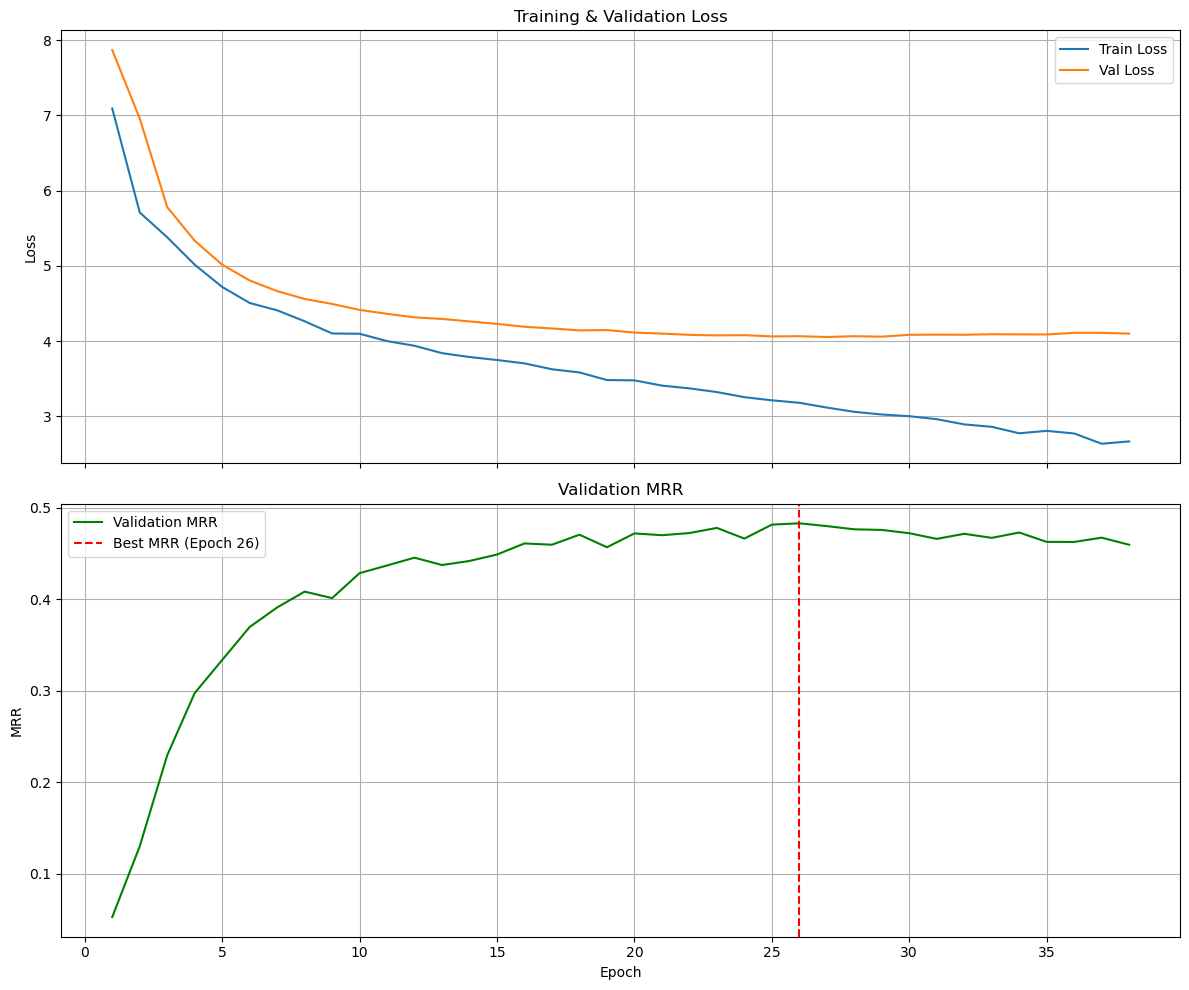

In [20]:
import matplotlib.pyplot as plt

# Load the history
history_df = pd.read_csv("training_history.csv")

# Plot Losses and MRR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Losses
ax1.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
ax1.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.set_title("Training & Validation Loss")

# Plot 2: MRR
ax2.plot(history_df['epoch'], history_df['MRR'], label='Validation MRR', color='green')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MRR")
ax2.legend()
ax2.grid(True)
ax2.set_title("Validation MRR")

# Find the best MRR epoch
best_mrr_epoch = history_df['MRR'].idxmax()
ax2.axvline(x=history_df.loc[best_mrr_epoch, 'epoch'], color='red', linestyle='--', label=f"Best MRR (Epoch {history_df.loc[best_mrr_epoch, 'epoch']})")
ax2.legend()

plt.tight_layout()
plt.savefig("training_plot.png")
print("Plot saved to training_plot.png")

Running evaluation...

CAPTION: "A man taking a rest in a shallow river amid the rocks ."
Ground Truth Image: 904404695.jpg
--- Top 5 Predictions ---
  1. 125319704.jpg (Score: 0.3307) 
  2. 904404695.jpg (Score: 0.3186) Correct!
  3. 2573667207.jpg (Score: 0.3081) 
  4. 2162564553.jpg (Score: 0.3010) 
  5. 2676015068.jpg (Score: 0.3010) 


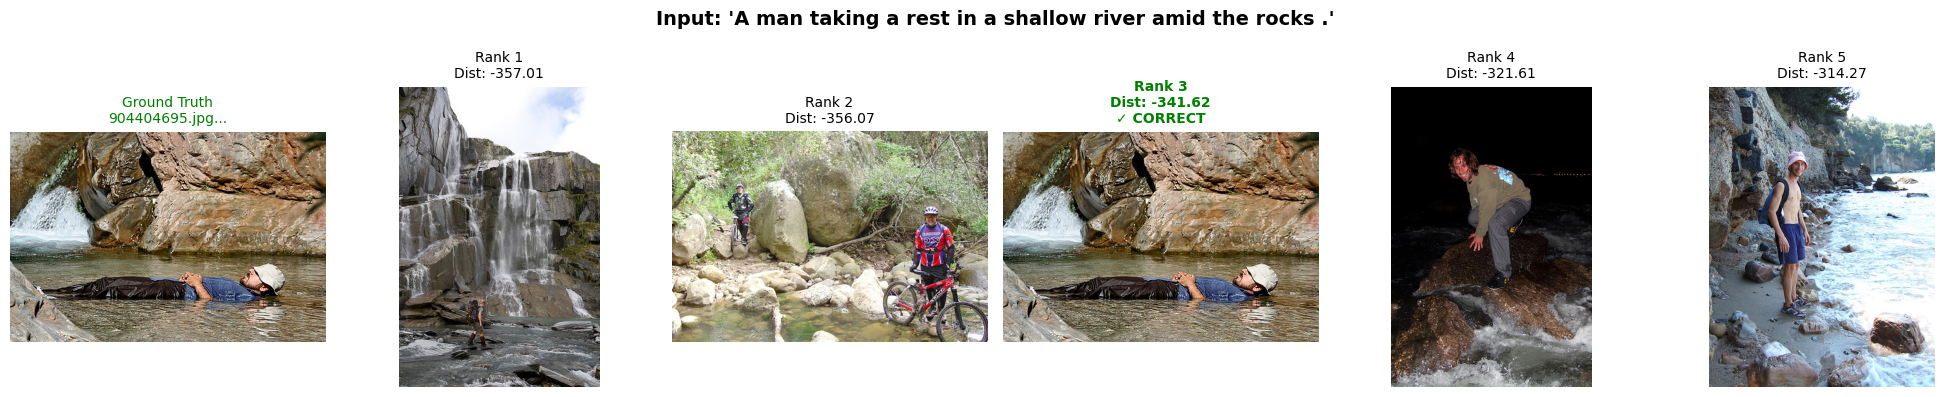


CAPTION: "A shirtless man is running down a wharf ."
Ground Truth Image: 4865304495.jpg
--- Top 5 Predictions ---
  1. 7123721879.jpg (Score: 0.2887) 
  2. 4865304495.jpg (Score: 0.2748) Correct!
  3. 3643666619.jpg (Score: 0.2324) 
  4. 5562469374.jpg (Score: 0.2308) 
  5. 4831663766.jpg (Score: 0.2254) 


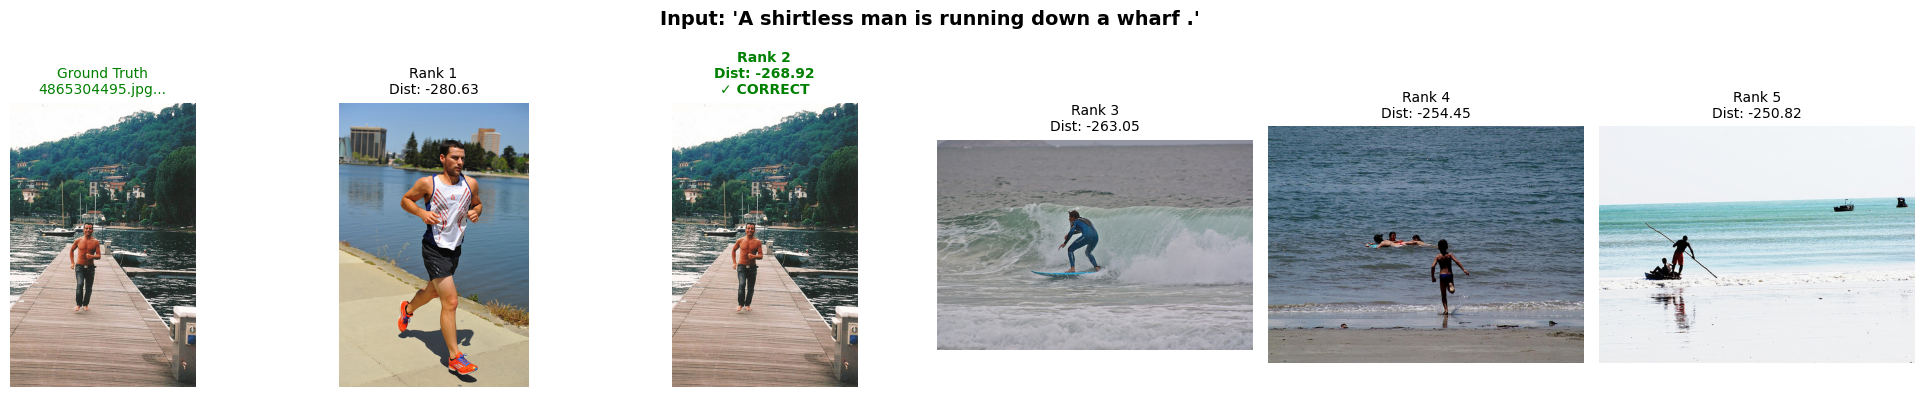


CAPTION: "A group of three violinists made up of two guys and one woman are playing while man in the audience closes his eyes ."
Ground Truth Image: 4037153114.jpg
--- Top 5 Predictions ---
  1. 3021024000.jpg (Score: 0.3791) 
  2. 4813062340.jpg (Score: 0.3602) 
  3. 8231853822.jpg (Score: 0.3411) 
  4. 4037153114.jpg (Score: 0.3230) Correct!
  5. 2445050754.jpg (Score: 0.3218) 


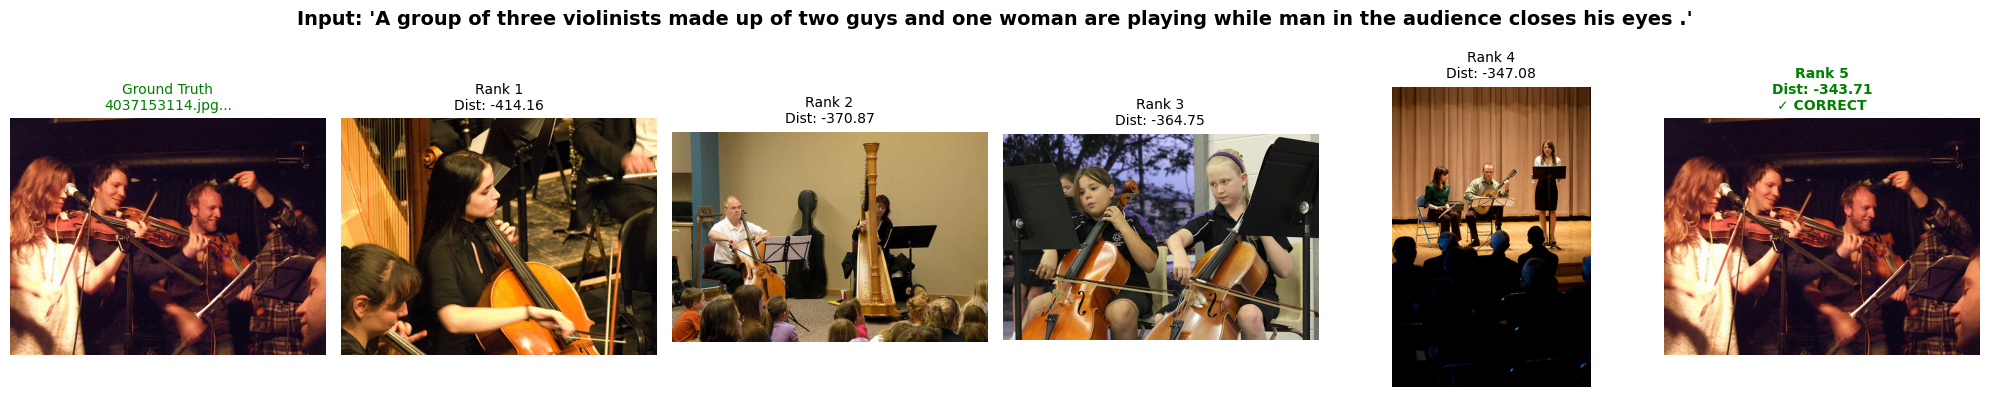


CAPTION: "An infant sitting on a cot reaching over to touch the face of an older boy ."
Ground Truth Image: 1417941060.jpg
--- Top 5 Predictions ---
  1. 424830334.jpg (Score: 0.2992) 
  2. 2509912399.jpg (Score: 0.2819) 
  3. 1402859872.jpg (Score: 0.2684) 
  4. 3143982558.jpg (Score: 0.2568) 
  5. 14955512.jpg (Score: 0.2466) 


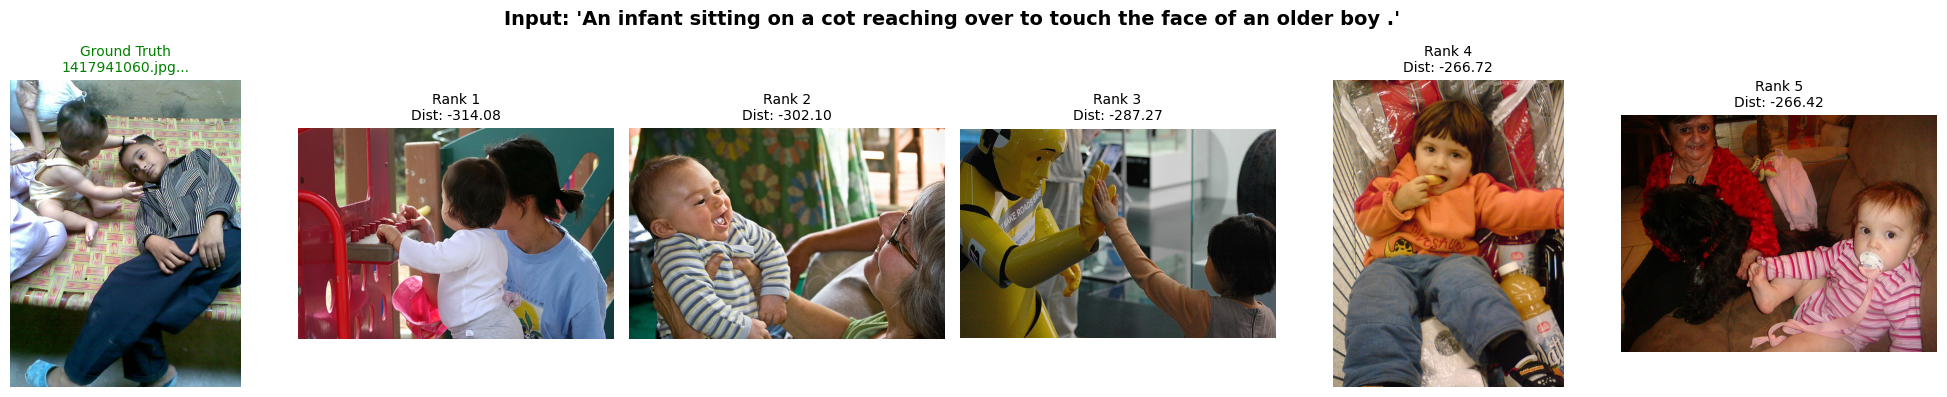


CAPTION: "A woman with dreadlocks and an olive green bag sits on red brick while checking the baby stroller ."
Ground Truth Image: 4447269544.jpg
--- Top 5 Predictions ---
  1. 103306033.jpg (Score: 0.2981) 
  2. 4785852807.jpg (Score: 0.2780) 
  3. 4755693778.jpg (Score: 0.2463) 
  4. 3643503169.jpg (Score: 0.2429) 
  5. 3134214072.jpg (Score: 0.2378) 


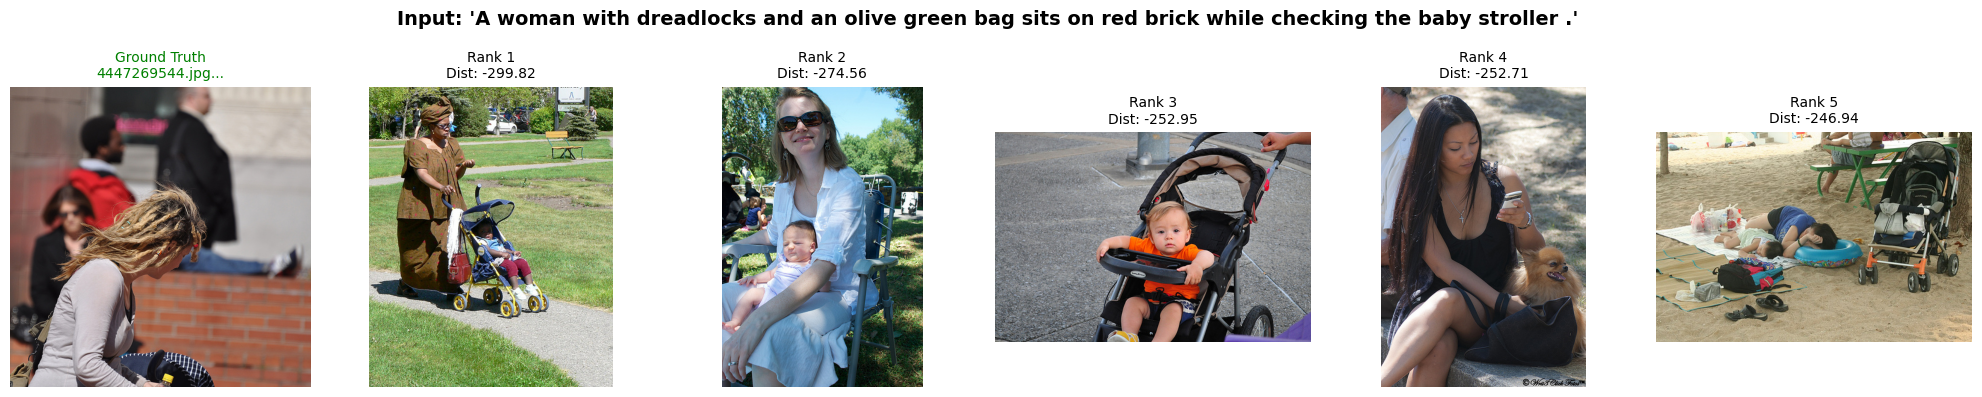

In [21]:
print("Running evaluation...")
model.eval()

# Get the correct validation image files and embeddings
val_img_files = train_data['images/names'][val_image_indices]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][val_image_indices]).to(DEVICE)

# Get the correct validation caption text
val_caption_text = train_data['captions/text'][val_caption_mask]

# Get the correct ground-truth mapping
# This is tricky: we need the index of the image *within the val_img_files*
val_label_matrix_full = train_data['captions/label'][val_caption_mask]
val_label_matrix_subset = val_label_matrix_full[:, val_image_indices]
# val_gt_indices[i] = index 'j' such that val_img_files[j] is the correct image for val_caption_text[i]
val_gt_indices = np.nonzero(val_label_matrix_subset)[1]


# Sample and visualize
for _ in range(5):
    idx = np.random.randint(0, len(X_val))
    
    caption_embd = X_val[idx]
    caption_text = val_caption_text[idx]
    gt_index_in_val_set = val_gt_indices[idx]

    with torch.no_grad():
        # Predict the image embedding from the caption
        pred_img_emb = model(caption_embd.to(DEVICE).unsqueeze(0)).cpu()
        
        # --- Corrected Metric: Cosine Similarity ---
        pred_img_emb_norm = F.normalize(pred_img_emb, p=2, dim=1)
        val_img_embd_norm = F.normalize(val_img_embd.cpu(), p=2, dim=1)
        
        # Find the most similar images
        similarities = pred_img_emb_norm @ val_img_embd_norm.T
        
        # Get top 5 scores and their indices
        top_k_scores, top_k_indices = torch.topk(similarities.squeeze(0), k=5)
        
        # ---
        
        print(f"\nCAPTION: \"{caption_text}\"")
        print(f"Ground Truth Image: {val_img_files[gt_index_in_val_set]}")
        print("--- Top 5 Predictions ---")
        for i in range(5):
            pred_idx = top_k_indices[i].item()
            score = top_k_scores[i].item()
            is_correct = "Correct!" if pred_idx == gt_index_in_val_set else ""
            print(f"  {i+1}. {val_img_files[pred_idx]} (Score: {score:.4f}) {is_correct}")

        # Note: The provided `visualize_retrieval` might be based on L2/MSE.
        # This manual printout uses the correct cosine similarity metric.
        # If you want to use `visualize_retrieval`, you'd need to adapt it.
        
        # To use the original visualizer (if it expects L2 distance):
        # We can pass the *predicted embedding* and let it calculate L2 distance,
        # but the model wasn't trained for that.
        
        visualize_retrieval(
            pred_img_emb, # The embedding, not scores
            gt_index_in_val_set,
            val_img_files,
            caption_text, 
            val_img_embd.cpu(), # The true embeddings
            k=5
        )

In [22]:
print("Generating submission file...")

test_data = load_data("data/test/test.clean.npz")
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()

# Put model in eval mode
model.eval()

pred_embds_list = []
test_loader = DataLoader(test_embds, batch_size=512) # Use large batch for inference

with torch.no_grad():
    # Use the rich progress bar
    with get_rich_progress_bar() as progress:
        task = progress.add_task("[magenta]Predicting Test Set", total=len(test_loader), loss=0.0)
        for batch_embds in test_loader:
            pred_batch = model(batch_embds.to(DEVICE)).cpu()
            pred_embds_list.append(pred_batch)
            progress.update(task, advance=1)

pred_embds = torch.cat(pred_embds_list, dim=0)

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission_new_improve2.csv')
print(f"Model saved to: {MODEL_PATH}")
print("Done.") 

c:\Users\Antonio\anaconda3\envs\GeometricCuda\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Generating submission file...


Generating submission file...
✓ Saved submission to submission_new_improve2.csv
Model saved to: models/mlp_best.pth
Done.
